In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import geopy.distance
from geopy.geocoders import Nominatim
import typing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

2022-09-26 10:47:40.296011: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-26 10:47:40.300646: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/anaconda3-2021-05/lib:/cm/shared/apps/pbspro-ce/19.1.3/lib/
2022-09-26 10:47:40.300661: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


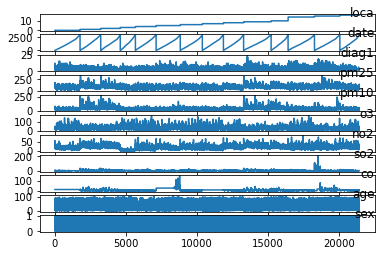

In [3]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
# load dataset
# dataset = read_csv('pollution.csv', header=0, index_col=0)
data=pd.read_parquet('~/run/AXA_AE_app/AE_AXA_poll-ae.parquet')
data['loca']=data.groupby('cd9_loc').ngroup()
data2=pd.DataFrame()
for loc in np.unique(data.loca):
    # data=pd.read_parquet('~/run/AXA_AE_app/AE_AXA_poll-ae.parquet')
    
    datum=data[data['loca']==loc]
    datum=datum.groupby(['loca','date','cd9_loc']).agg('mean')[['pm25','pm10','o3','no2','so2','co','age','sex','diag1']]
    datum.reset_index(inplace=True)
    idx = pd.date_range(min(data['date']), max(data['date']))
    datum.index = pd.DatetimeIndex(datum['date'])#.fillna()

    # s.index = pd.DatetimeIndex(s.index)

    datum = datum.reindex(idx, fill_value=np.nan)
    datum['date']=datum.index
    datum['loca']=loc #fillna(method='ffill',inplace=True)
    if datum['pm25'].isna().sum() < 2922/1.5: 
        data2=pd.concat([data2,datum],axis=0)
# data2['date']=data2.index
data=data2
# data['loca'].fillna(method='ffill',inplace=True)
# data.reset_index(inplace=True)
# data['loca']=data.groupby('cd9_loc').ngroup()
data['date']=(data['date']-data['date'][0]).dt.days

data=data[['loca','cd9_loc','date','pm25','pm10','o3','no2','so2','co','age','sex','diag1']]
data=data.groupby(['loca','cd9_loc','date']).agg('mean')[['pm25','pm10','o3','no2','so2','co','age','sex','diag1']]

data.age=np.round(data.age)
data.sex=np.round(data.sex)
data.sort_values(by=['loca','date'],inplace=True)
first_column = data.pop('diag1')
data.insert(0, 'diag1', first_column)
data.reset_index(inplace=True)
data.fillna(method='bfill',inplace=True)
data.fillna(method='ffill',inplace=True)
dataset = data.drop(['cd9_loc'],axis=1).values

# specify columns to plot
groups = [0, 1,2, 3, 4, 5, 6, 7, 8,9,10]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(dataset[:, group])
	plt.title(data.drop(['cd9_loc'],axis=1).columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [4]:
geolocator = Nominatim(user_agent="example app")
df_loc=pd.DataFrame(columns=['lat','long','name'])
for ii,i in enumerate(pd.unique(data['cd9_loc'])):
    a,b,c=geolocator.geocode(str(i)+", Hong Kong").point
    df_loc[ii]=[a,b,i]
df_loc=df_loc.transpose()
df_loc.columns=['lat','long','name']
df_loc=df_loc[3:]

In [5]:
data_loc=df_loc
data_loc['latlon'] = list(zip(data_loc['lat'], data_loc['long']))

square = pd.DataFrame(
    np.zeros((data_loc.shape[0], data_loc.shape[0])),
    index=data_loc.index, columns=data_loc.index
)

def get_distance(col):
    end = data_loc.loc[col.name, 'latlon']
    return data_loc['latlon'].apply(geopy.distance.distance,
                              args=(end,),
                              ellipsoid='WGS-84'
                             )
distances = square.apply(get_distance, axis=1).T

data_loc['src']=data_loc['name']
data_loc['dst']=data_loc['name']

# np.sum((distances<5)*1)
D_D=pd.DataFrame((distances<5)*1)
D_D.index=data_loc['src']
D_D.columns=data_loc['dst']

E_E=pd.DataFrame(D_D.stack())#.reset_index(inplace=True)
# E_E.rename=['source','target']#.reset_index(inplace=True)#.rename(columns={'level_0':'Source','level_1':'Target', 0:'Weight'})
E_E.reset_index(inplace=True)#
distance_mat=E_E[E_E[0]>0]

distance=distances
distance.index=data_loc['src']
distance.columns=data_loc['dst']
distance=pd.DataFrame(distance.stack())
distance.reset_index(inplace=True)

#prepare for TF

distances=distances.astype(str) # df.astype(np.float64)#lues.as_int#('int')#.to_numpy()
distances=distances.replace('km', '', regex=True)
distances=distances.astype(np.float64)
distances.shape

(14, 14)

In [6]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = 10
adjacency_matrix =distances[distances<=10].fillna(0) # compute_adjacency_matrix(route_distances, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix != 0)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 14, number of edges: 64


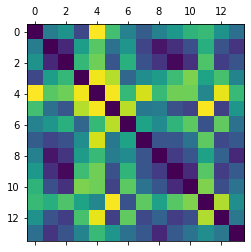

In [7]:
plt.figure(figsize=(4, 4))
plt.matshow(distances, 0)

In [66]:
def preprocess(data: np.ndarray, train_size: float, val_size: float):

    dataset = data.drop(['loca','date'],axis=1).values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(dataset)

    x_scaled = scaled[:,1:data.shape[1]].astype('float32') #.drop('diag1',axis=1).values.astype('float32')
    y_scaled = dataset[:,1:].astype('float32') #['diag1'].values.astype('float32')
    # integer encode direction
    encoder = LabelEncoder()

    # y_scaled = scaler.fit_transform(y_values)

    # specify the number of lag days
    n_days = 14
    n_features =  x_scaled.shape[1]
    # frame as supervised learning

    x_reframed = series_to_supervised(x_scaled, n_days, 1).values
    y_reframed = y_scaled#series_to_supervised(y_scaled).values
    y_reframed = y_reframed[:x_reframed.shape[0]]

    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        x_scaled, y_scaled, sequence_length=14)

    # split into train and test sets
    # values = reframed.values
    d_train=.5
    d_test=.25
    n_train_days = 365*round((len(x_scaled)/365)*d_train) #* 24
    n_test_days = 365*round((len(x_scaled)/365)*(d_test)) #* 24
    n_valid_days= n_train_days+n_test_days
    n_obs = n_days * n_features

    X_train = x_reframed[:n_train_days, :n_obs]
    X_test = x_reframed[n_train_days:n_valid_days, :n_obs]
    X_valid = x_reframed[n_valid_days:, :n_obs]

    Y_train = y_reframed[:n_train_days]
    Y_test = y_reframed[n_train_days:n_valid_days,:]
    Y_valid = y_reframed[n_valid_days:, :]

    dim0=round(len(np.unique(data.loca)))

    # reshape input to be 4D [loc,samples, timesteps, features]
    X_train = X_train.reshape((round(X_train.shape[0]/dim0), n_days,dim0, n_features))
    X_test = X_test.reshape((round(X_test.shape[0]/dim0), n_days,dim0, n_features))
    X_valid = X_valid.reshape((round(X_valid.shape[0]/dim0), n_days,dim0, n_features))

    # reshape output to be D [loc,samples, timesteps, prevalence or incidence]
    Y_train=Y_train.reshape(round(Y_train.shape[0]/dim0),dim0,n_features)
    Y_test=Y_test.reshape(round(Y_test.shape[0]/dim0),dim0,n_features)
    Y_valid=Y_valid.reshape(round(Y_valid.shape[0]/dim0),dim0,n_features)
    
    return X_train, Y_train, X_test, Y_test,X_valid, Y_valid


In [62]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

In [63]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)

In [68]:
in_feat = 8
batch_size = 64
epochs = 20
input_sequence_length = 21
forecast_horizon = 7
multi_horizon = False
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)
model.fit(
    Y_train,
    validation_data=Y_valid,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().